## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [3]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/dmel/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/dmel/'
gtf_name = 'Drosophila_melanogaster.BDGP6.32.103.gtf'
mutation = 'Fmr1'
samp_num = '3'
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [4]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [5]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [6]:
# clear up some memory by deleting original transcript list
transcripts.clear()

# Loading up the csv file.

In [7]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

## Determine KS statistic for all transcripts

In [8]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    p_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, protein_coding):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
            position = np.array(list(range(len(tr_m))))
            smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001)
            smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001)
            ks = max(abs(cumul_m - cumul_c))
            n = len(tr_m)
            m = len(tr_c)
            en = (n*m)/(n+m)
            p = kstwo.sf(ks,np.round(en))
            ks_list.append(ks)
            p_list.append(p)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            

    # Calculate the -10 log of the P values in order to visualize the smallest values. 
    log_p = []
    for p in p_list:
        if p != 0:
            log_p.append(math.log(p, 0.1))
        else:
            log_p.append(200)
            
    # reorganizing the lists into a dataframe. 
    df = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, p_list, log_p)))
    df.columns = ["gene_ID","transcript_ID", "ks_stat", "p_value", "-10logp"]
    df.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

In [10]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

Text(0.5, 1.0, 'KS statistic of all mouse transcripts')

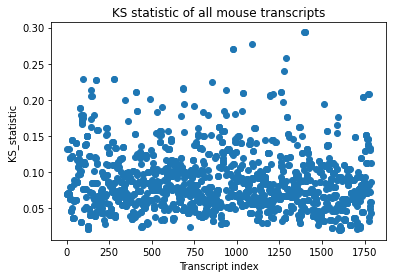

In [11]:
plt.scatter(list(range(len(df["ks_stat"]))), df["ks_stat"])
plt.ylabel("KS_statistic")
plt.xlabel("Transcript index")
plt.title("KS statistic of all mouse transcripts")

Text(0.5, 1.0, '-10log transformed p-values of all KS tests (mouse)')

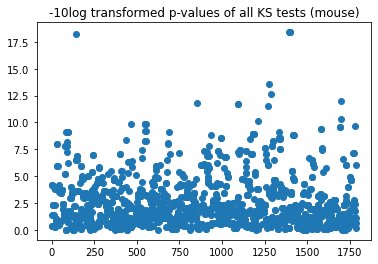

In [12]:
plt.scatter(list(range(len(df["-10logp"]))), df["-10logp"])
#plt.ylabel("P-value")
#plt.xlabel("Transcript index")
plt.title("-10log transformed p-values of all KS tests (mouse)")
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

In [13]:
# Load in the table of Fmr1 targets
Fmr1_targets = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/Fmr1_targets.csv')

Text(0.5, 1.0, '-10log transformed p-values of all KS tests (mouse)')

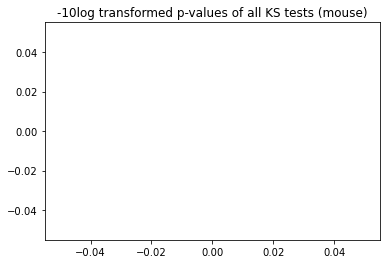

In [15]:
# plot the -10log p_values for the Fmr1 targets
df2 = pd.merge(df, Fmr1_targets, how = "inner", left_on="gene_ID", right_on="FLY")
plt.scatter(list(range(len(df2['-10logp']))), df2['-10logp'])
#plt.ylabel("P-value")
#plt.xlabel("Transcript index")
plt.title("-10log transformed p-values of all KS tests (mouse)")
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

## Observe the count arrays for the genes with the smallest P-value after conducting the KS-test. 

In [16]:
# find all of the genes with P-values below a certain threshold. 
diff_dist = list(zip(df["transcript_ID"][df['-10logp'] > 11],df["gene_ID"][df['-10logp'] > 11]))

In [17]:
diff_dist

[('FBtr0079261', 'epsilonCOP'),
 ('FBtr0076511', 'mRpL12'),
 ('FBtr0346646', 'eIF3a'),
 ('FBtr0078944', 'eIF3a'),
 ('FBtr0083006', 'RpS5b'),
 ('FBtr0308031', 'RpS5b'),
 ('FBtr0083277', 'mtSSB'),
 ('FBtr0302369', 'RpL34a'),
 ('FBtr0084972', 'RpL34a'),
 ('FBtr0084973', 'RpL34a'),
 ('FBtr0073898', 'yl')]

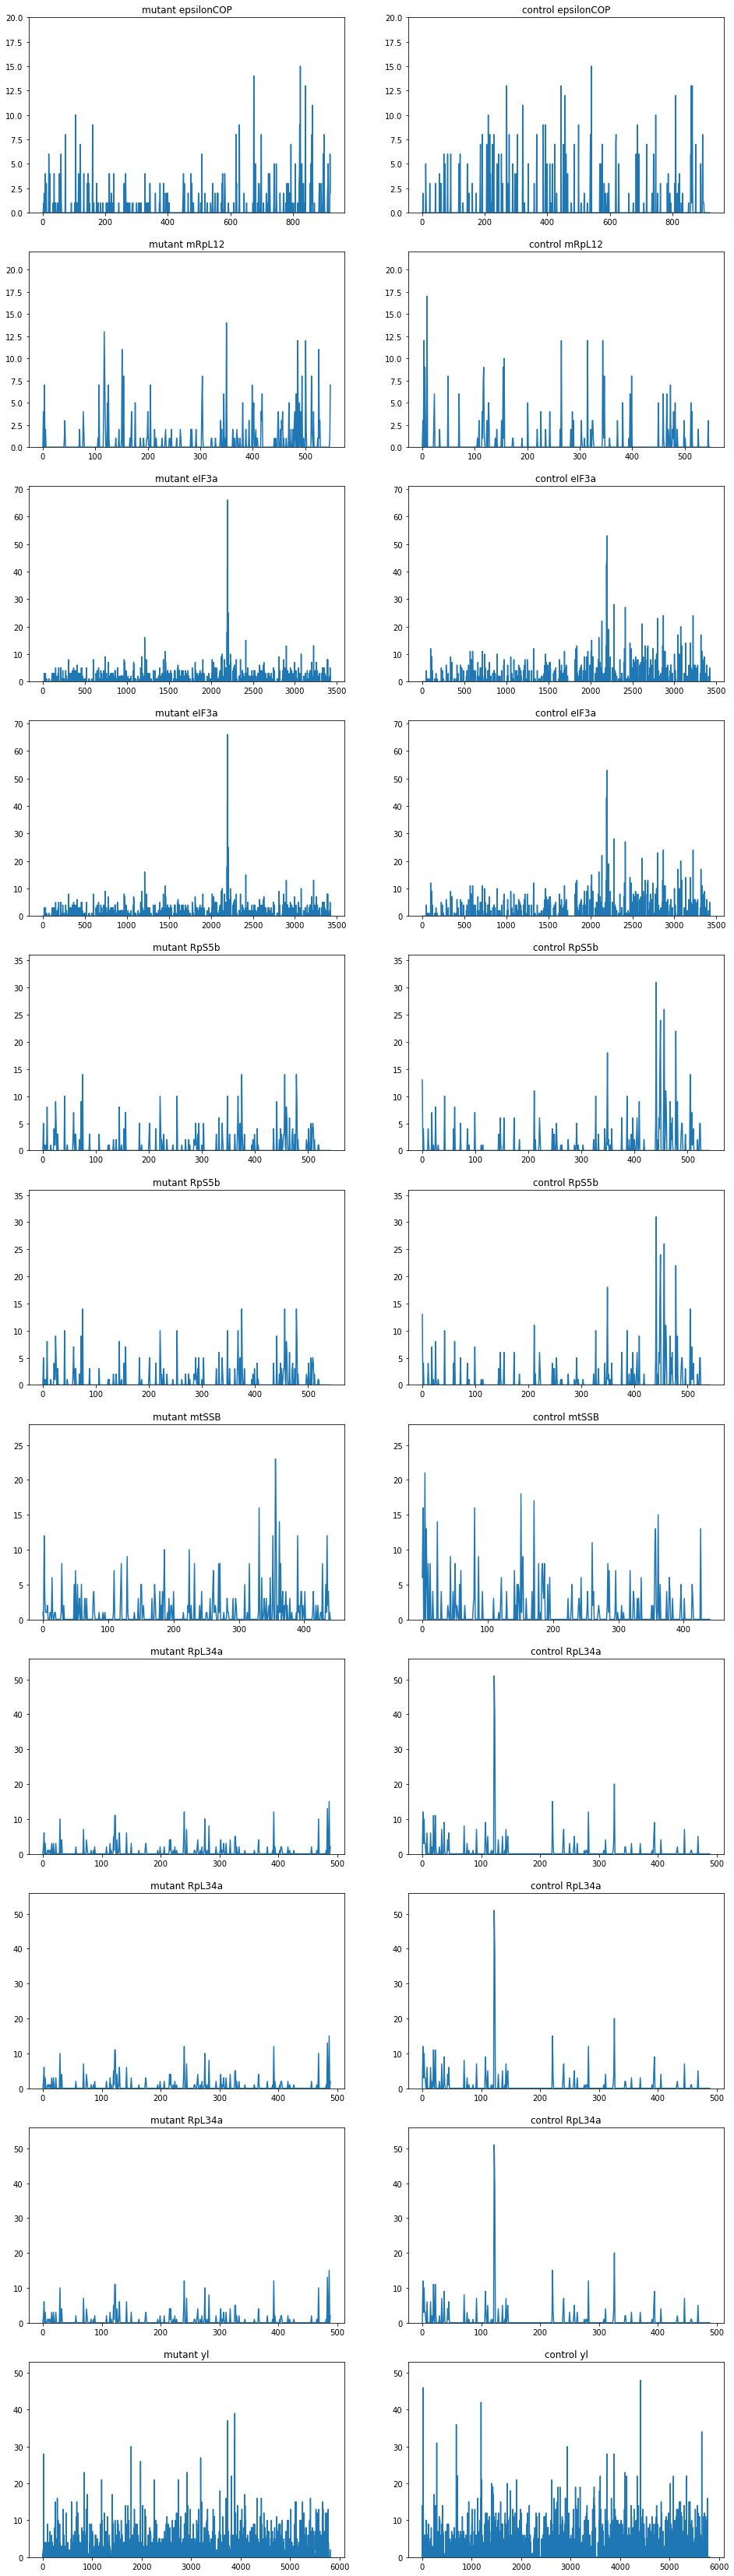

In [19]:
ax = kat.big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (16,60), fontsize = 12)

## Choose the gene of interest and smooth out the array.

In [32]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts('yl', 
                                           protein_coding, data_mutant, data_control)

In [33]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [34]:
sum(my_vec_control)

6986

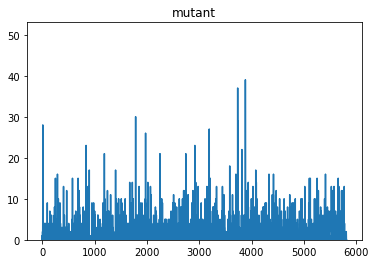

Text(0.5, 1.0, 'control')

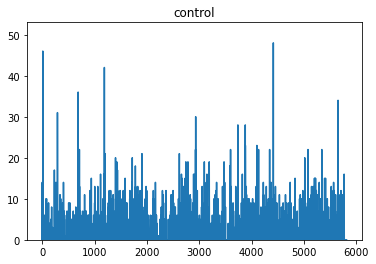

In [35]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.plot(my_vec_mutant)
plt.ylim([0,maxi+5])
plt.title("mutant")
plt.show()
plt.plot(my_vec_control)
plt.ylim([0,maxi+5])
plt.title("control")

In [36]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_position, my_vec_control+0.00000000001)

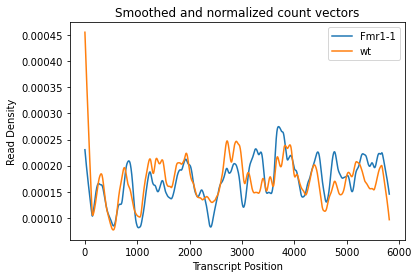

In [37]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

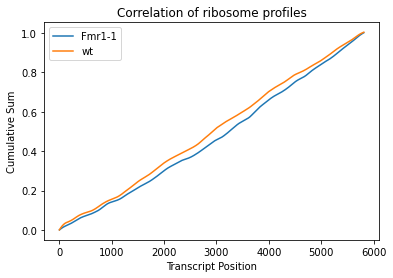

In [38]:
plt.plot(my_position, cumul_m, label = "Fmr1-1")
plt.plot(my_position, cumul_c, label = "wt")
plt.ylabel("Cumulative Sum")
plt.xlabel("Transcript Position")
plt.title("Correlation of ribosome profiles")
plt.legend()

In [39]:
ks = max(abs(cumul_m - cumul_c))
n = len(my_vec_mutant)
m = len(my_vec_control)
en = (n*m)/(n+m)
p = kstwo.sf(ks,np.round(en))

In [40]:
p

4.909422481666399e-11